In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter

import pandas_datareader.data as web

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

import theano
import pymc3 as pm
import arviz
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

AttributeError: module 'numpy.distutils.__config__' has no attribute 'blas_opt_info'

In [ ]:
from pathlib import Path
from freqtrade.configuration import Configuration

path='user_data/configs/'

config = Configuration.from_files([path + "config_binance_zone.json"])

data_location = Path(config['user_data_dir'], 'data', 'binance')

In [ ]:
from freqtrade.data.history import load_pair_history
pairBTC = "BTC_BUSD"
candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pairBTC)

In [ ]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

/tmp/ipykernel_12/3040959772.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [ ]:
np.random.seed(42)
sns.set_style('dark')

In [ ]:
def format_plot(axes, i, p, y, trials, success, true_p, tmle, tmap=None):
    fmt = FuncFormatter(lambda x, _: f'{x:.0%}')
    if i >= 6:
        axes[i].set_xlabel("$p$, Success Probability")
        axes[i].xaxis.set_major_formatter(fmt)
    else:
        axes[i].axes.get_xaxis().set_visible(False)
    if i % 3 == 0:
        axes[i].set_ylabel("Posterior Probability")
    axes[i].set_yticks([])

    axes[i].plot(p, y, lw=1, c='k')
    axes[i].fill_between(p, y, color='darkblue', alpha=0.4)
    axes[i].vlines(true_p, 0, max(10, np.max(y)), color='k', linestyle='--', lw=1)
    axes[i].set_title(f'Trials: {trials:,f} - Success: {success:,f}')
    if i > 0:
        smle = r"$\theta_{{\mathrm{{MLE}}}}$ = {:.2%}".format(tmle)
        axes[i].text(x=.02, y=.85, s=smle, transform=axes[i].transAxes)
        smap = r"$\theta_{{\mathrm{{MAP}}}}$ = {:.2%}".format(tmap)
        axes[i].text(x=.02, y=.75, s=smap, transform=axes[i].transAxes)    
    return axes[i]

## Simulate Coin Tosses & Updates of Posterior

/home/ftuser/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ftuser/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


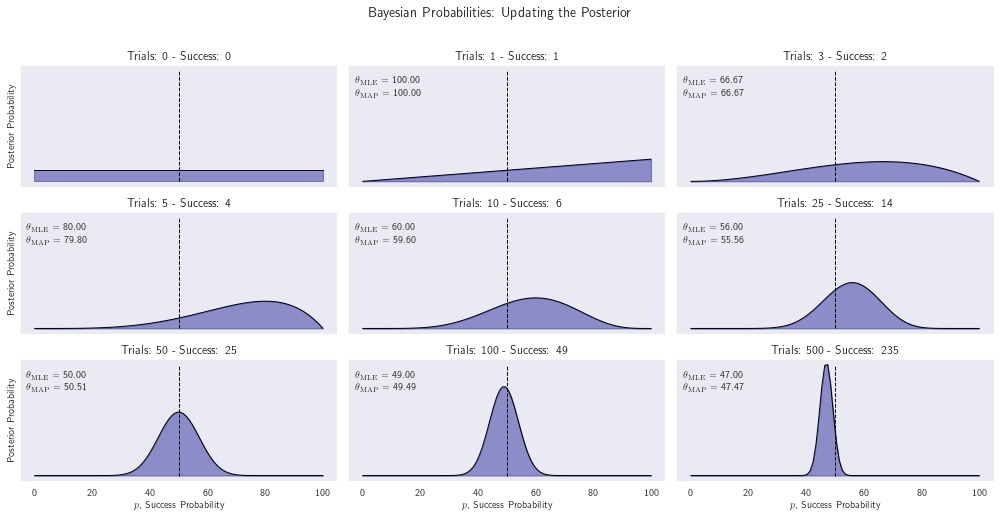

In [ ]:

n_trials = [0, 1, 3, 5, 10, 25, 50, 100, 500]
outcomes = stats.bernoulli.rvs(p=0.5, size=n_trials[-1])
p = np.linspace(0, 1, 100)
# uniform (uninformative) prior
a = b = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7), sharex=False)

axes = axes.flatten()
fmt = FuncFormatter(lambda x, _: f'{x:.0%}')
for i, trials in enumerate(n_trials):
    successes = outcomes[:trials]
    theta_mle = np.mean(successes)
    heads = sum(successes)
    tails = trials - heads
    update = stats.beta.pdf(p, a + heads , b + tails)
    theta_map = pd.Series(update, index=p).idxmax()
    axes[i] = format_plot(axes, i, p, update, trials=trials, success=heads, 
                          true_p=.5, tmle=theta_mle, tmap=theta_map)

title = 'Bayesian Probabilities: Updating the Posterior'
fig.suptitle(title,  y=1.02, fontsize=14, )
fig.tight_layout()

In [ ]:
from freqtrade.data.history import load_pair_history
dataFrames = np.array([4])

dataFrames_btc = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair="BTC_USDT")

dataFrames_bnb = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair="BNB_USDT")
dataFrames_btc

,date,open,high,low,close,volume
0,2017-08-17 04:00:00+00:00,4261.48,4349.99,4261.32,4349.99,82.088865
1,2017-08-17 08:00:00+00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2,2017-08-17 12:00:00+00:00,4436.06,4485.39,4333.42,4352.34,174.562001
3,2017-08-17 16:00:00+00:00,4352.33,4354.84,4200.74,4325.23,225.109716
4,2017-08-17 20:00:00+00:00,4307.56,4369.69,4258.56,4285.08,249.769913
...,...,...,...,...,...,...
9464,2021-12-11 12:00:00+00:00,48240.43,48943.92,48160.00,48747.02,3968.264310
9465,2021-12-11 16:00:00+00:00,48745.11,49276.00,48385.98,48407.25,4611.816290
9466,2021-12-11 20:00:00+00:00,48407.25,49485.71,48390.22,49389.99,3455.476680
9467,2021-12-12 00:00:00+00:00,49389.99,49699.95,49022.90,49305.70,4316.437530


In [ ]:
dataFrames_btc['return'] = dataFrames_btc['close'].pct_change()
# btc_binary = (sp500_returns.pct_change().dropna() > 0).astype(int)
dataFrames_btc['cumluative_return'] = np.exp(np.log1p(dataFrames_btc['return']).cumsum())


In [ ]:
dataFrames_btc['binary'] = (dataFrames_btc['return'].pct_change().dropna() > 0).astype(int)
dataFrames_btc = dataFrames_btc.dropna()

n_days = [0, 1, 3, 5, 10, 25, 50, 100, 500]
btc_return=dataFrames_btc['return']
btc_return.iloc[:n_days[-1]]
dataFrames_btc

NameError: name 'dataFrames_btc' is not defined

/home/ftuser/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ftuser/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ftuser/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ftuser/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ftuser/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ftuser/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ftuser/.local/lib/pyth

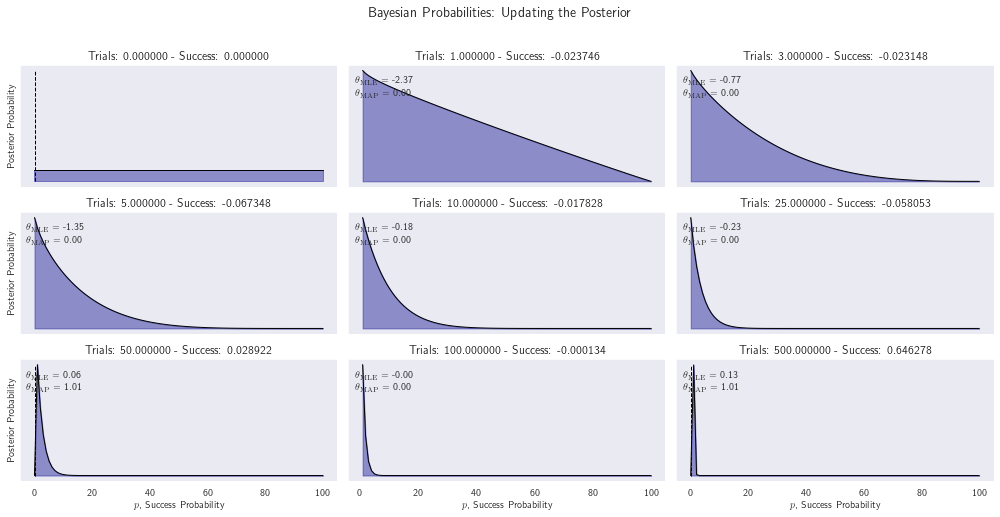

In [ ]:
# random sample of trading days
# outcomes = sp500_binary.sample(n_days[-1])

# initial 500 trading days
outcomes = btc_return.iloc[:n_days[-1]]
p = np.linspace(0, 1, 100)

# uniform (uninformative) prior
a = b = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7), sharex=False)
axes = axes.flatten()
for i, days in enumerate(n_days):
    successes = outcomes.iloc[:days]
    theta_mle = successes.mean()
    up = successes.sum()
    down = days - up
    update = stats.beta.pdf(p, a + up , b + down)
    theta_map = pd.Series(update, index=p).idxmax()
    axes[i] = format_plot(axes, i, p, update, trials=days, success=up, 
                          true_p=btc_return.mean(), tmle=theta_mle, tmap=theta_map)

title = 'Bayesian Probabilities: Updating the Posterior'
fig.suptitle(title,  y=1.02, fontsize=14)
fig.tight_layout()